# Results: QPSK SOI + OFDM (QPSK) Interference

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append("..")
sys.path.append("../..")

import pickle
import numpy as np
import matplotlib.pyplot as plt

import rfcutils2.qpsk_helper_fn as qpskfn

import torch

2023-05-19 14:02:17.398583: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 14:02:17.889546: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-19 14:02:17.889588: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-19 14:02:17.889592: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [ ]:
from tueplots import bundles
plt.rcParams.update({"figure.dpi": 300})
plt.rcParams.update(bundles.neurips2022())
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.labelsize']=12

In [6]:
def view_as_complex(x): 
    return torch.view_as_complex(x.transpose(2, 1).contiguous()).numpy()

## Compute the second-order statistics for LMMSE Estimation

In [8]:
rrc_mtx = pickle.load(open('../rrcmtx_2560.pkl', 'rb'))
cov_s = np.matmul(rrc_mtx, rrc_mtx.conj().T)
cov_b = pickle.load(open('ofdm_cov.pkl', 'rb'))

all_filt = {}
for sir_db in [0, -3, -6, -9, -12, -15, -18, -21, -24]:
    coeff = np.sqrt(10**(-sir_db / 10)) * np.sqrt(64 / 56)
    Cyy = cov_s + coeff ** 2 * cov_b
    Csy = cov_s.copy()
    U, S, Vh = np.linalg.svd(Cyy, hermitian=True)
    sthr_idx = np.linalg.matrix_rank(Cyy) + 1
    Cyy_inv = np.matmul(
        U[:, :sthr_idx], np.matmul(np.diag(1.0 / S[:sthr_idx]), U[:, :sthr_idx].conj().T)
    )
    lmmse_filt = np.matmul(Csy, Cyy_inv)
    all_filt[sir_db] = lmmse_filt
    
def lmmse_estimation(y, sir_db):
    coeff = np.sqrt(10**(-sir_db / 10)) * np.sqrt(64/56)
    return np.matmul(all_filt[sir_db], coeff * y.T).T

## Load the UNet Model

In [5]:
import unet_model as unet
nn_model = unet.get_unet_model((2560,2), long_k_sz=101, custommodel=False)
nn_model.load_weights(f'../checkpoints/UNetK101_0502_RRCQPSK_OFDMQPSK_2560_BSz_256_SamSz50000')
def unet_predict(y, sinr_db):
    coeff = np.sqrt(10**(-sinr_db/10)) * np.sqrt(64/56)
    y2 = coeff*y
    sig_mixture_comp = np.dstack((y2.real, y2.imag))
    all_sig1_est_comp = nn_model.predict(sig_mixture_comp, verbose=0)
    return all_sig1_est_comp[:,:,0] + 1j*all_sig1_est_comp[:,:,1]

## Compute Metrics for MF, LMMSE and UNet

In [ ]:
cases = [
    'qpsk_ofdm_qpsk_aRGS_Scale_kappa_AnalyticalModel', 
    'qpsk_ofdm_qpsk_aRGS_Scale_kappa_TrainedModel',
    'qpsk_ofdm_qpsk_BASIS_AnalyticalModel',
    'qpsk_ofdm_qpsk_ModifiedBASIS_Scale_invkappa_AnalyticalModel',
    'qpsk_ofdm_qpsk_ReverseDiffusion'
]

# One-time baselines
one_time_baselines_done = False
all_ber_mf, all_ber_lmmse, all_mse_lmmse = [], [], []
all_ber_unet, all_mse_unet = [], []

n_per_sinr = 100
for sinr_db in [-3, -6, -9, -12, -15, -18, -21,-24]:
    for idx in range(100, 100 + n_per_sinr):
        y, qpsk, ofdm, _ = pickle.load(open(f'../metrics/{cases[0]}/sample_{sinr_db}dB_{idx}.pkl','rb'))
        sig_lmmse = lmmse_estimation(view_as_complex(y), sinr_db)
        sig_unet_est = unet_predict(view_as_complex(y), sinr_db)

        bit_true, _ = qpskfn.qpsk_matched_filter_demod(view_as_complex(qpsk))
        bit_mf, _ = qpskfn.qpsk_matched_filter_demod(view_as_complex(y))
        bit_lmmse, _ = qpskfn.qpsk_matched_filter_demod(sig_lmmse.astype(np.complex64))
        bit_unet, _ = qpskfn.qpsk_matched_filter_demod(sig_unet_est)

        ber_mf = np.mean(bit_true != bit_mf)
        ber_lmmse = np.mean(bit_true != bit_lmmse)
        ber_unet = np.mean(bit_true != bit_unet)

        all_ber_mf.append(ber_mf)
        all_ber_lmmse.append(ber_lmmse)
        all_ber_unet.append(ber_unet)

        mse_lmmse = np.mean(np.abs(sig_lmmse - view_as_complex(qpsk)) ** 2)
        mse_unet = np.mean(np.abs(sig_unet_est - view_as_complex(qpsk)) ** 2)

        all_mse_lmmse.append(mse_lmmse)
        all_mse_unet.append(mse_unet)
    
    print(
        "{:>3}dB, {:.03f}, {:.03f}, {:.03f}, {:.03f}, {:.03f}".format(
            sinr_db, np.mean(all_ber_mf[-n_per_sinr:]), np.mean(all_ber_lmmse[-n_per_sinr:]), 
            10*np.log10(np.mean(all_mse_lmmse[-n_per_sinr:])), np.mean(all_ber_unet[-n_per_sinr:]), 
            10*np.log10(np.mean(all_mse_unet[-n_per_sinr:])))
    )    
print()

pickle.dump((all_mse_lmmse, all_mse_unet, all_ber_mf, all_ber_lmmse, all_ber_unet), open(f'../metrics/qpsk_ofdm_qpsk_baselines.pkl', 'wb'))

## Compute Metrics for aRGS, BASIS, Modified BASIS and Reverse Diffusion

In [ ]:
cases = [
    'qpsk_ofdm_qpsk_aRGS_Scale_kappa_AnalyticalModel', 
    'qpsk_ofdm_qpsk_aRGS_Scale_kappa_TrainedModel',
    'qpsk_ofdm_qpsk_BASIS_AnalyticalModel',
    'qpsk_ofdm_qpsk_ModifiedBASIS_Scale_invkappa_AnalyticalModel',
    'qpsk_ofdm_qpsk_ReverseDiffusion'
]

n_per_sinr = 100
for ff in cases:
    all_ber_est, all_mse_est = [], []
    for sinr_db in [-3, -6, -9, -12, -15, -18, -21,-24]:
        for idx in range(100, 100 + n_per_sinr):
            y, qpsk, ofdm, s_pred = pickle.load(open(f'../metrics/{ff}/sample_{sinr_db}dB_{idx}.pkl','rb'))

            bit_true, _ = qpskfn.qpsk_matched_filter_demod(view_as_complex(qpsk))
            bit_pred, _ = qpskfn.qpsk_matched_filter_demod(view_as_complex(s_pred.cpu()))

            ber_est = np.mean(bit_true != bit_pred)
            all_ber_est.append(ber_est)

            mse_est = np.mean(np.abs(view_as_complex(s_pred.cpu()) - view_as_complex(qpsk))**2)
            all_mse_est.append(mse_est)
        
        print(
            "{:>3}dB, {:.03f}, {:.03f}, {:.03f}, {:.03f}, {:.03f}, {:.03f}, {:8.03f}, {:.03f}, {:8.03f}, {:.03f}, {:8.03f}".format(
                sinr_db, np.mean(all_ber_est[-n_per_sinr:]), 10*np.log10(np.mean(all_mse_est[-n_per_sinr:])))
        )    
    print()
    pickle.dump((all_mse_est, all_ber_est), open(f'../metrics/{ff}.pkl', 'wb'))

In [5]:
all_mse_lmmse, all_mse_unet, all_ber_mf, all_ber_lmmse, all_ber_unet = pickle.load(open(f'../metrics/qpsk_ofdm_qpsk_baselines.pkl', 'rb'))
all_mse_proj_only, all_ber_proj_only = pickle.load(open(f'../metrics/qpsk_ofdm_qpsk_ReverseDiffusion.pkl', 'rb'))
all_mse_basismod, all_ber_basismod = pickle.load(open(f'../metrics/qpsk_ofdm_qpsk_ModifiedBASIS_Scale_invkappa_AnalyticalModel.pkl', 'rb'))

In [6]:
sinr_ax = [-3, -6, -9, -12, -15, -18, -21, -24]
cases_to_compare = [
    'qpsk_ofdm_qpsk_aRGS_Scale_kappa_AnalyticalModel', 
    'qpsk_ofdm_qpsk_aRGS_Scale_kappa_TrainedModel',
]
legend_notes = ['Analytical SOI Model', 'Trained SOI Model']
linestyles = ['*-', 'x-.']
n_per_sinr = 100
custom_legend_ordering_BER1 = [0, 1, 4, 3, 2]
custom_legend_ordering_MSE1 = [0, 3, 2, 1]
custom_legend_ordering_BER2 = [0, 1, 2, 5, 4, 3, 6]
custom_legend_ordering_MSE2 = [0, 1, 4, 3, 2, 5]

## Compare aRGS with MF, LMMSE and Modified BASIS

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


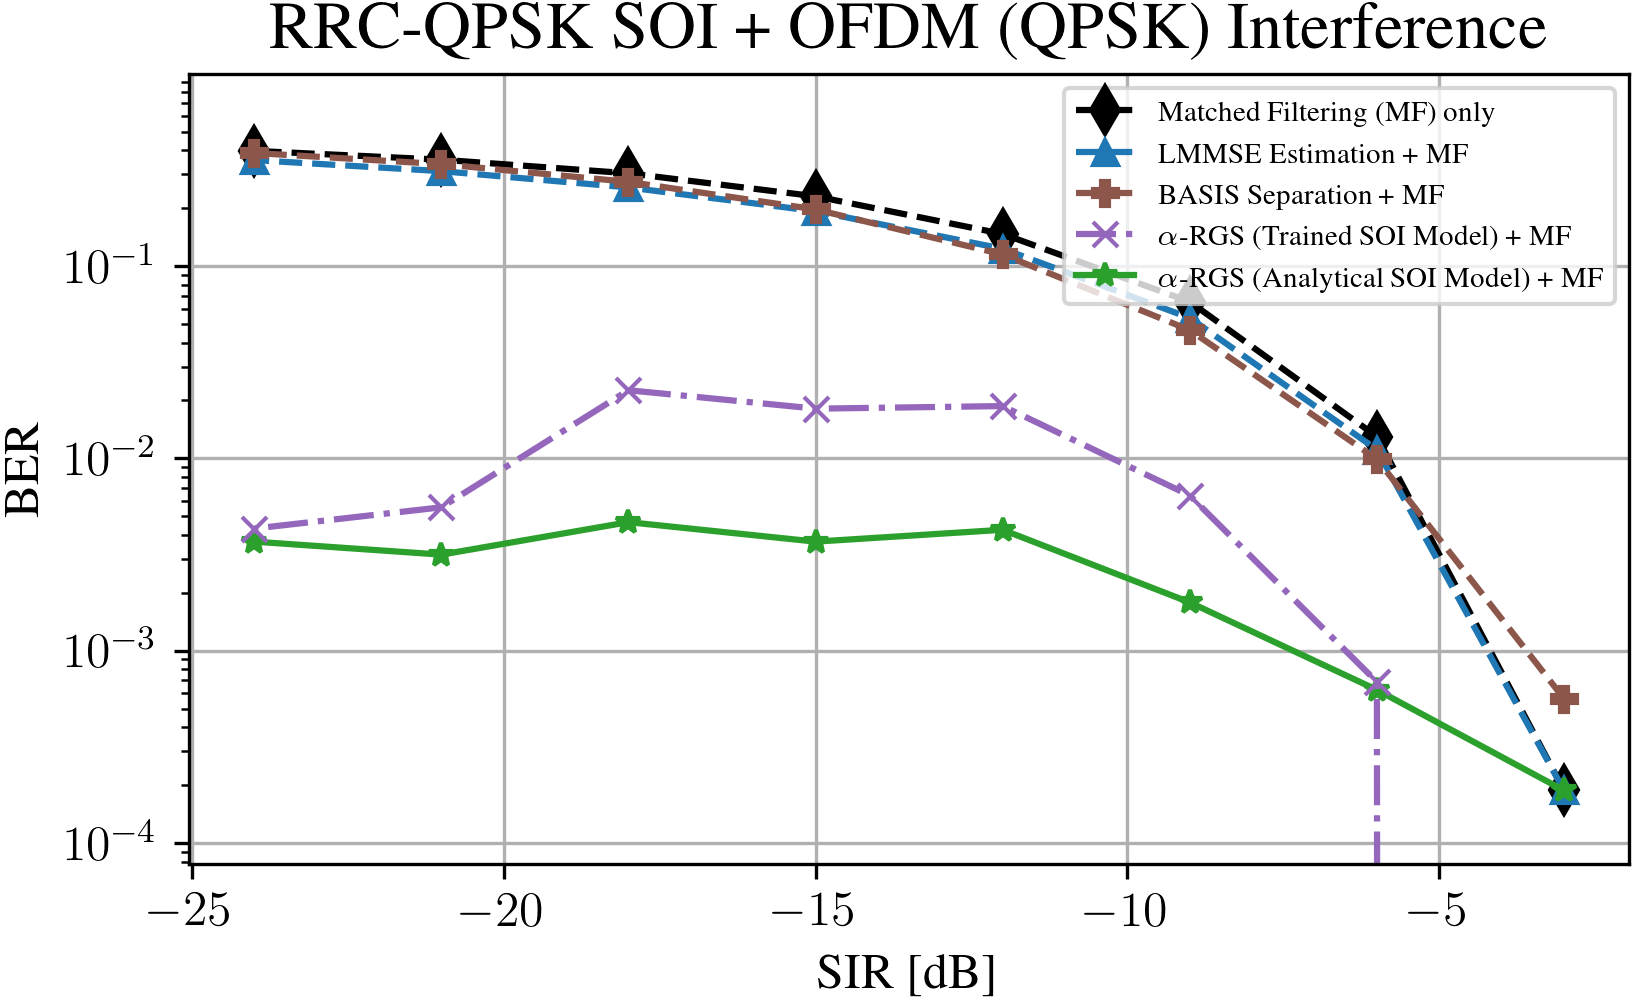

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


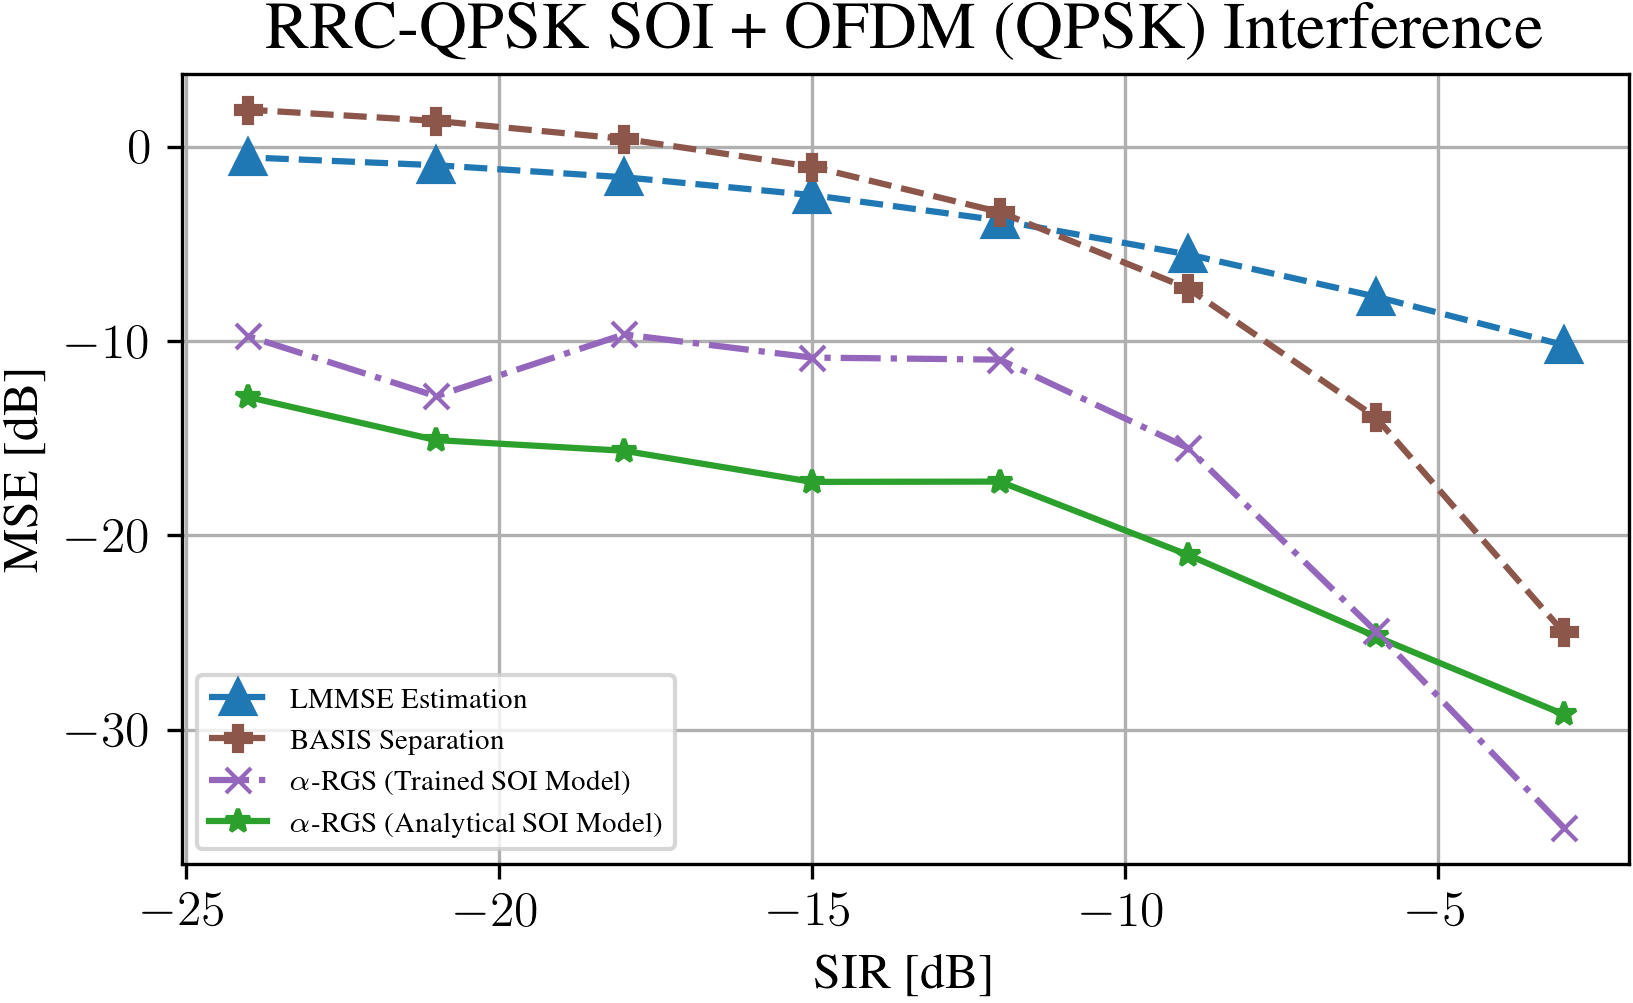

In [23]:
# Plot the traditional baselines
plt.semilogy(sinr_ax, np.mean(np.array(all_ber_mf).reshape(-1,n_per_sinr), axis=-1), 'kd--', label='Matched Filtering (MF) only', markersize=8)
plt.semilogy(sinr_ax, np.mean(np.array(all_ber_lmmse).reshape(-1,n_per_sinr), axis=-1), '^--', label='LMMSE Estimation + MF')
plt.plot([],[]) # skip orange

# Plot aRGS
for ii, ff in enumerate(cases_to_compare):
    all_mse_est, all_ber_est = pickle.load(open(f'../metrics/{ff}.pkl', 'rb'))
    ber_averages = np.mean(np.array(all_ber_est).reshape(8,-1), axis=-1)
    plt.semilogy(sinr_ax, ber_averages, linestyles[ii], label=f'$\\alpha$-RGS ({legend_notes[ii]}) + MF')
    if ii == 0:
        plt.plot([],[]) # skip red

# Plot Modified BASIS
ber_basismod_averages = np.mean(np.array(all_ber_basismod).reshape(-1,n_per_sinr), axis=-1)
plt.semilogy(sinr_ax, ber_basismod_averages, 'P--', label='BASIS Separation + MF', zorder=2)

plt.legend(*([ x[i] for i in custom_legend_ordering_BER1 ] for x in plt.gca().get_legend_handles_labels()), loc='upper right')
plt.grid()
plt.ylim([3.125e-4/4, 0.999])
plt.xlabel('SIR [dB]')
plt.ylabel('BER')
plt.title(f'RRC-QPSK SOI + OFDM (QPSK) Interference', fontsize=16)
plt.savefig('../figs/RRCQPSK_OFDMQPSK_BER_Test.eps', bbox_inches='tight')
plt.savefig('../figs/RRCQPSK_OFDMQPSK_BER_Test.png', bbox_inches='tight', dpi=600)
plt.show()

plt.figure()
plt.plot(sinr_ax, 10*np.log10(np.mean(np.array(all_mse_lmmse).reshape(-1,n_per_sinr), axis=-1)), '^--', label='LMMSE Estimation', markersize=8)
plt.plot([],[]) # skip orange

for ii, ff in enumerate(cases_to_compare):
    all_mse_est, all_ber_est = pickle.load(open(f'../metrics/{ff}.pkl', 'rb'))
    plt.plot(sinr_ax, 10*np.log10(np.mean(np.array(all_mse_est).reshape(8,-1), axis=-1)), linestyles[ii], label=f'$\\alpha$-RGS ({legend_notes[ii]})')
    if ii == 0:
        plt.plot([],[]) # skip red

plt.plot(sinr_ax, 10*np.log10(np.mean(np.array(all_mse_basismod).reshape(-1,n_per_sinr), axis=-1)), 'P--', label='BASIS Separation', zorder=2)

plt.legend(*([ x[i] for i in custom_legend_ordering_MSE1 ] for x in plt.gca().get_legend_handles_labels()))
plt.grid()
plt.xlabel('SIR [dB]')
plt.ylabel('MSE [dB]')
plt.title(f'RRC-QPSK SOI + OFDM (QPSK) Interference', fontsize=16)
plt.savefig('../figs/RRCQPSK_OFDMQPSK_MSE_Test.eps', bbox_inches='tight')
plt.savefig('../figs/RRCQPSK_OFDMQPSK_MSE_Test.png', bbox_inches='tight', dpi=600)
plt.show()

## Compare aRGS with UNet and Reverse Diffusion as well

**Caveat:** UNet is not a fair comparison as it was trained with paired data in a supervised fashion. We nevertheless show that our method can perform nearly as well as UNet without cumbersome joint training.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


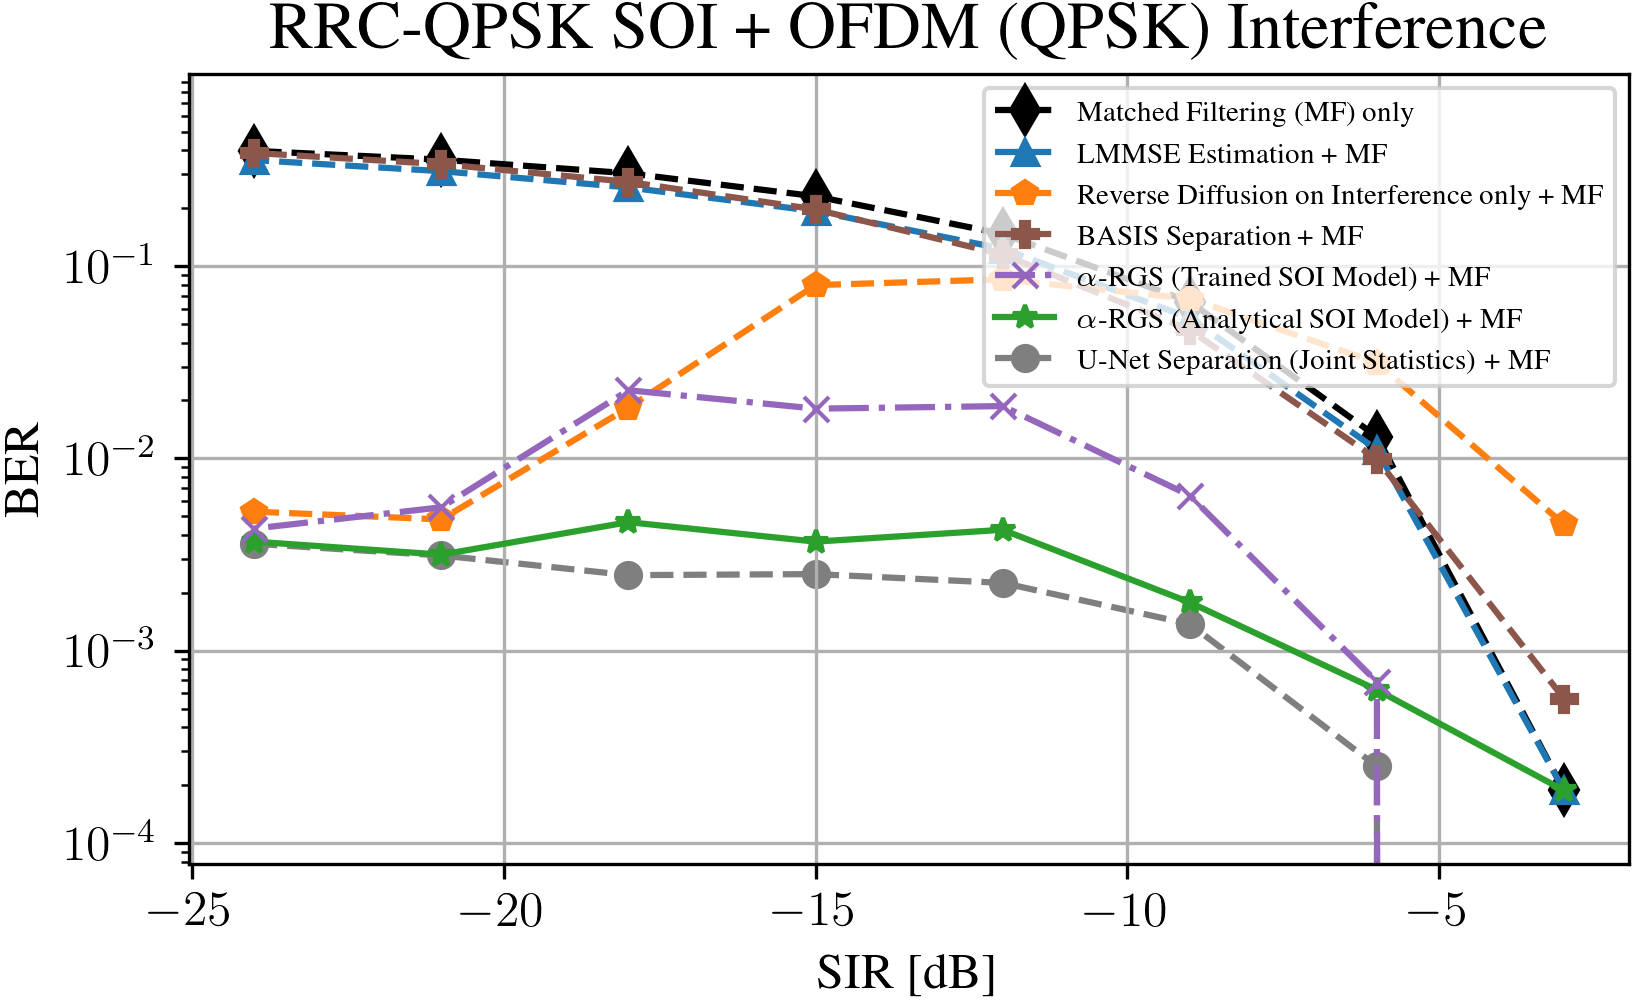

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


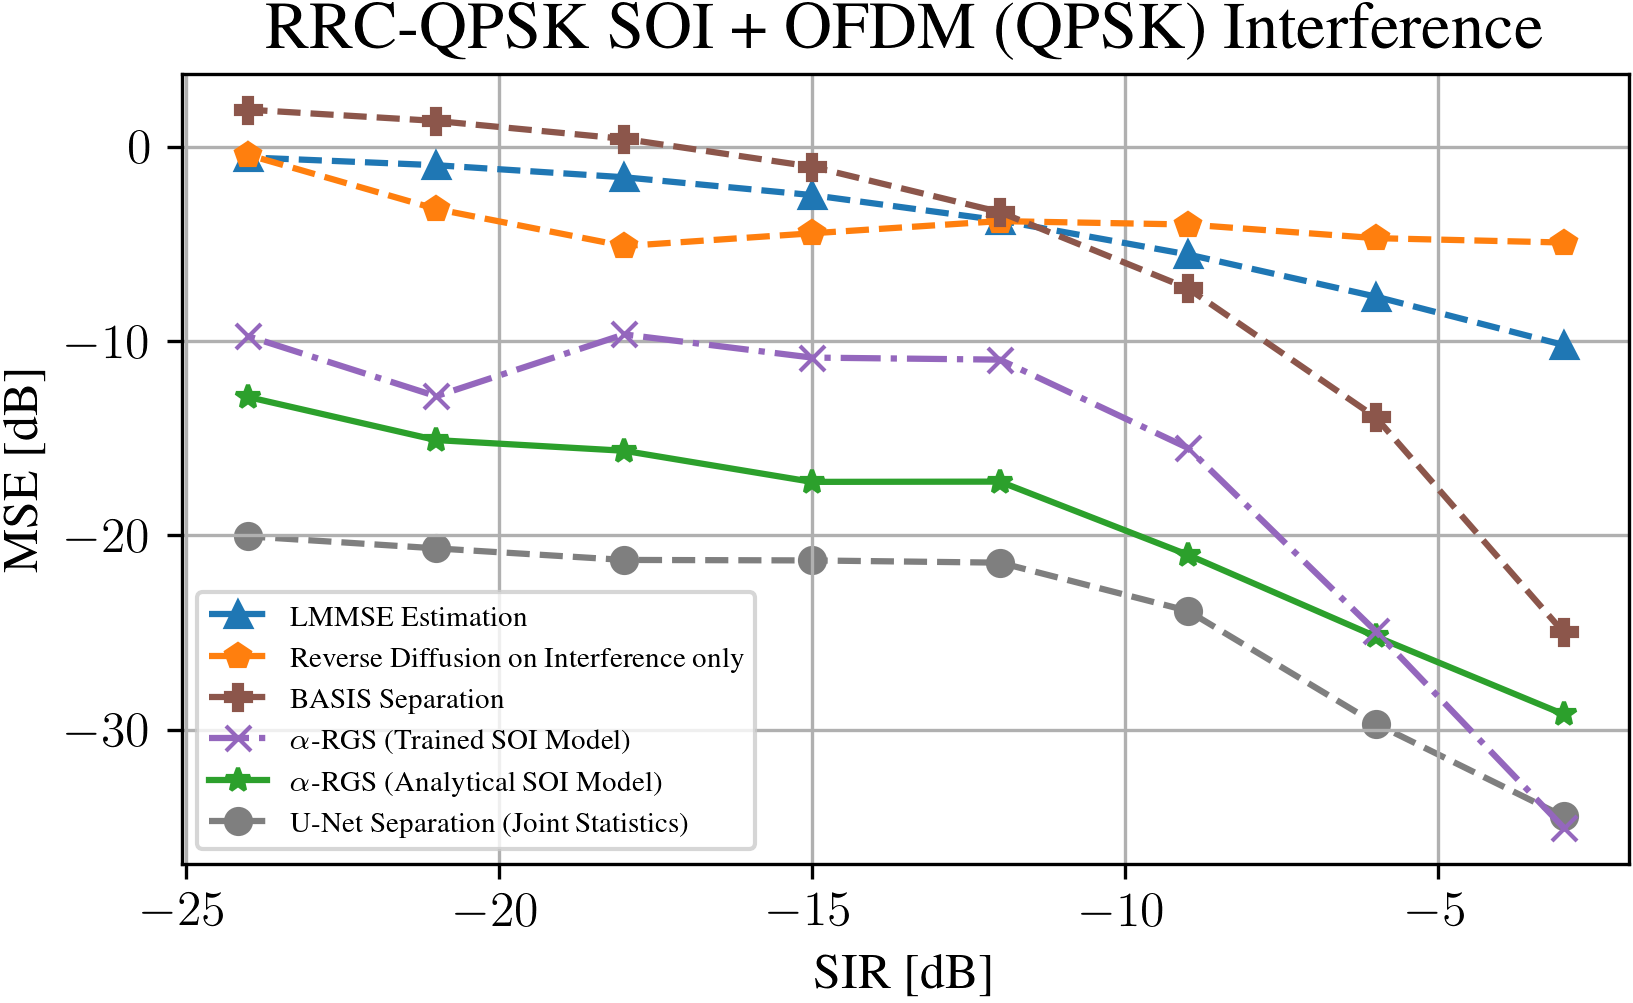

In [24]:
plt.semilogy(sinr_ax, np.mean(np.array(all_ber_mf).reshape(-1,n_per_sinr), axis=-1), 'kd--', label='Matched Filtering (MF) only', markersize=8)
plt.semilogy(sinr_ax, np.mean(np.array(all_ber_lmmse).reshape(-1,n_per_sinr), axis=-1), '^--', label='LMMSE Estimation + MF')
plt.semilogy(sinr_ax, np.mean(np.array(all_ber_proj_only).reshape(-1,n_per_sinr), axis=-1), 'p--', label='Reverse Diffusion on Interference only + MF')
for ii, ff in enumerate(cases_to_compare):
    all_mse_est, all_ber_est = pickle.load(open(f'../metrics/{ff}.pkl', 'rb'))
    ber_averages = np.mean(np.array(all_ber_est).reshape(8,-1), axis=-1)
    plt.semilogy(sinr_ax, ber_averages, linestyles[ii], label=f'$\\alpha$-RGS ({legend_notes[ii]}) + MF')
    if ii == 0:
        plt.plot([],[]) # skip red
ber_basismod_averages = np.mean(np.array(all_ber_basismod).reshape(-1,n_per_sinr), axis=-1)
plt.semilogy(sinr_ax, ber_basismod_averages, 'P--', label='BASIS Separation + MF', zorder=2)
plt.plot([],[]) # skip pink
plt.semilogy(sinr_ax, np.mean(np.array(all_ber_unet).reshape(-1,n_per_sinr), axis=-1), 'o--', label='U-Net Separation (Joint Statistics) + MF', zorder=1)
plt.legend(*([ x[i] for i in custom_legend_ordering_BER2 ] for x in plt.gca().get_legend_handles_labels()), loc='upper right')
plt.grid()
plt.ylim([3.125e-4/4, 0.999])
plt.xlabel('SIR [dB]')
plt.ylabel('BER')
plt.title(f'RRC-QPSK SOI + OFDM (QPSK) Interference', fontsize=16)
plt.savefig('../figs/RRCQPSK_OFDMQPSK_BER_Test_Extra.eps', bbox_inches='tight')
plt.savefig('../figs/RRCQPSK_OFDMQPSK_BER_Test_Extra.png', bbox_inches='tight', dpi=600)
plt.show()

plt.figure()
plt.plot(sinr_ax, 10*np.log10(np.mean(np.array(all_mse_lmmse).reshape(-1,n_per_sinr), axis=-1)), '^--', label='LMMSE Estimation')
plt.plot(sinr_ax, 10*np.log10(np.mean(np.array(all_mse_proj_only).reshape(-1,n_per_sinr), axis=-1)), 'p--', label='Reverse Diffusion on Interference only')
for ii, ff in enumerate(cases_to_compare):
    all_mse_est, all_ber_est = pickle.load(open(f'../metrics/{ff}.pkl', 'rb'))
    plt.plot(sinr_ax, 10*np.log10(np.mean(np.array(all_mse_est).reshape(8,-1), axis=-1)), linestyles[ii], label=f'$\\alpha$-RGS ({legend_notes[ii]})')
    if ii == 0:
        plt.plot([],[]) # skip red
plt.plot(sinr_ax, 10*np.log10(np.mean(np.array(all_mse_basismod).reshape(-1,n_per_sinr), axis=-1)), 'P--', label='BASIS Separation', zorder=2)
plt.plot([],[]) # skip pink
plt.plot(sinr_ax, 10*np.log10(np.mean(np.array(all_mse_unet).reshape(-1,n_per_sinr), axis=-1)), 'o--', label='U-Net Separation (Joint Statistics)', zorder=1)
plt.legend(*([ x[i] for i in custom_legend_ordering_MSE2 ] for x in plt.gca().get_legend_handles_labels()))
plt.grid()
plt.xlabel('SIR [dB]')
plt.ylabel('MSE [dB]')
plt.title(f'RRC-QPSK SOI + OFDM (QPSK) Interference', fontsize=16)
plt.savefig('../figs/RRCQPSK_OFDMQPSK_MSE_Test_Extra.eps', bbox_inches='tight')
plt.savefig('../figs/RRCQPSK_OFDMQPSK_MSE_Test_Extra.png', bbox_inches='tight', dpi=600)
plt.show()

## Plot the Same Results with Error Bars

In [48]:
def get_mean_stderr(all_mse, all_ber):
    mse = np.array(all_mse).reshape(8,-1)
    ber = np.array(all_ber).reshape(8,-1)
    
    mse_mean = np.mean(mse, axis=-1)
    mse_stderr = np.std(mse, ddof=1, axis=-1)/np.sqrt(mse.shape[-1])
    
    ber_mean = np.mean(ber, axis=-1)
    ber_stderr = np.std(ber, ddof=1, axis=-1)/np.sqrt(ber.shape[-1])
    
    return mse_mean, mse_stderr, ber_mean, ber_stderr

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


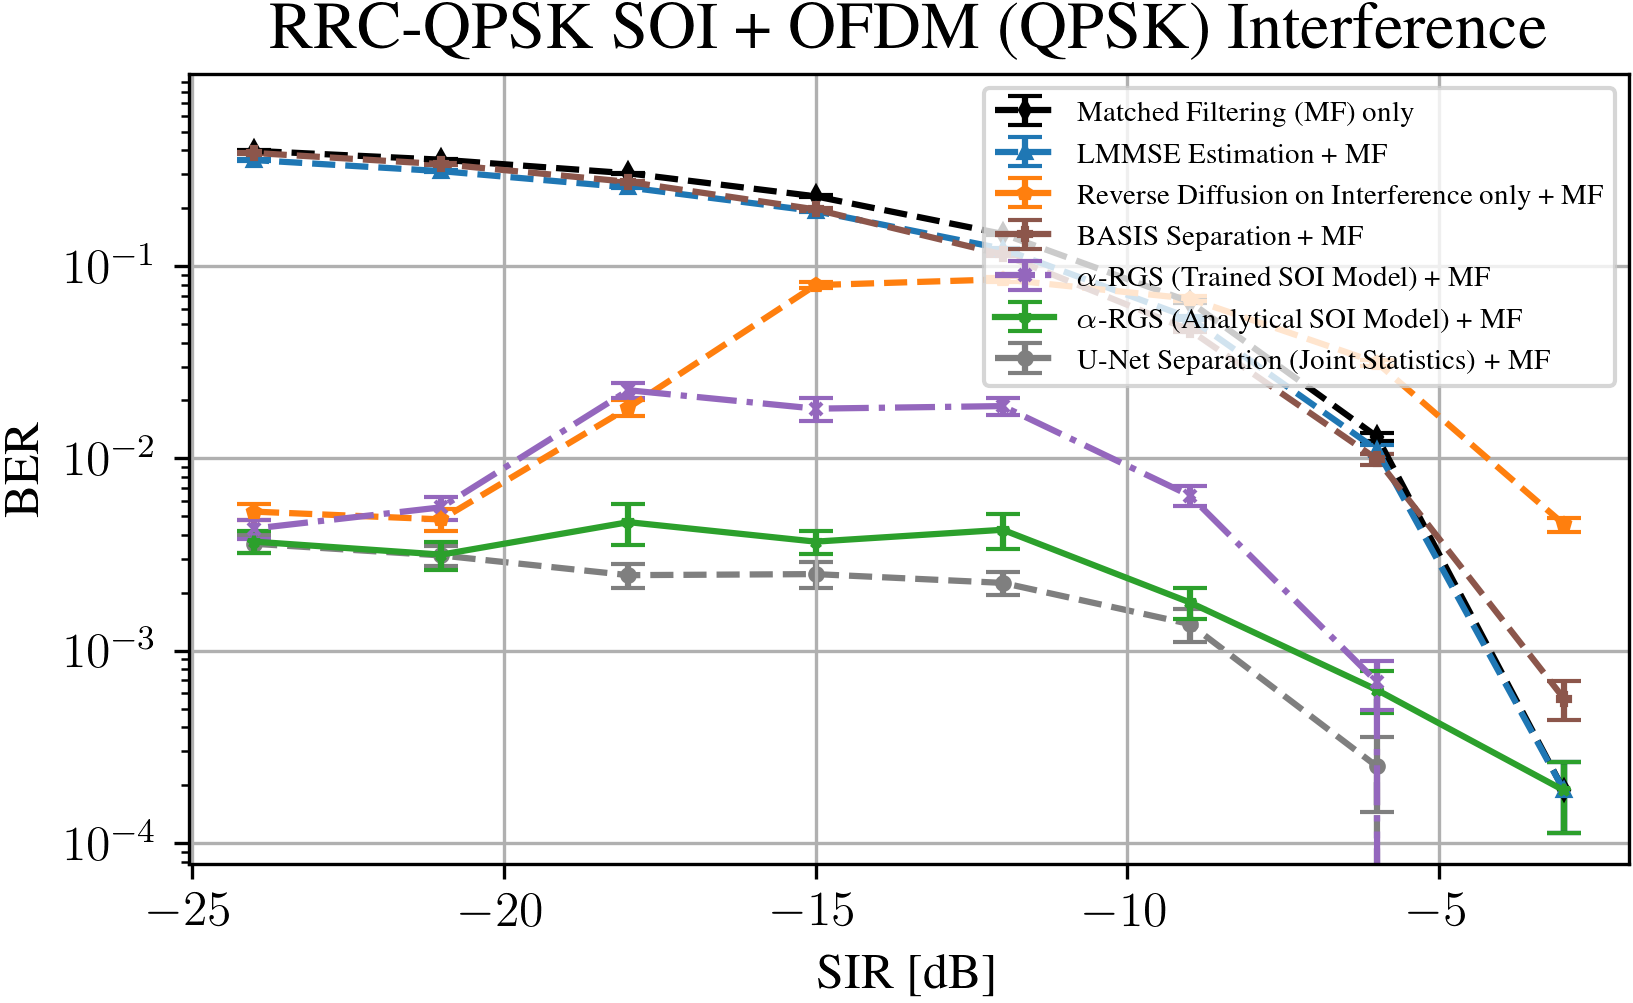

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


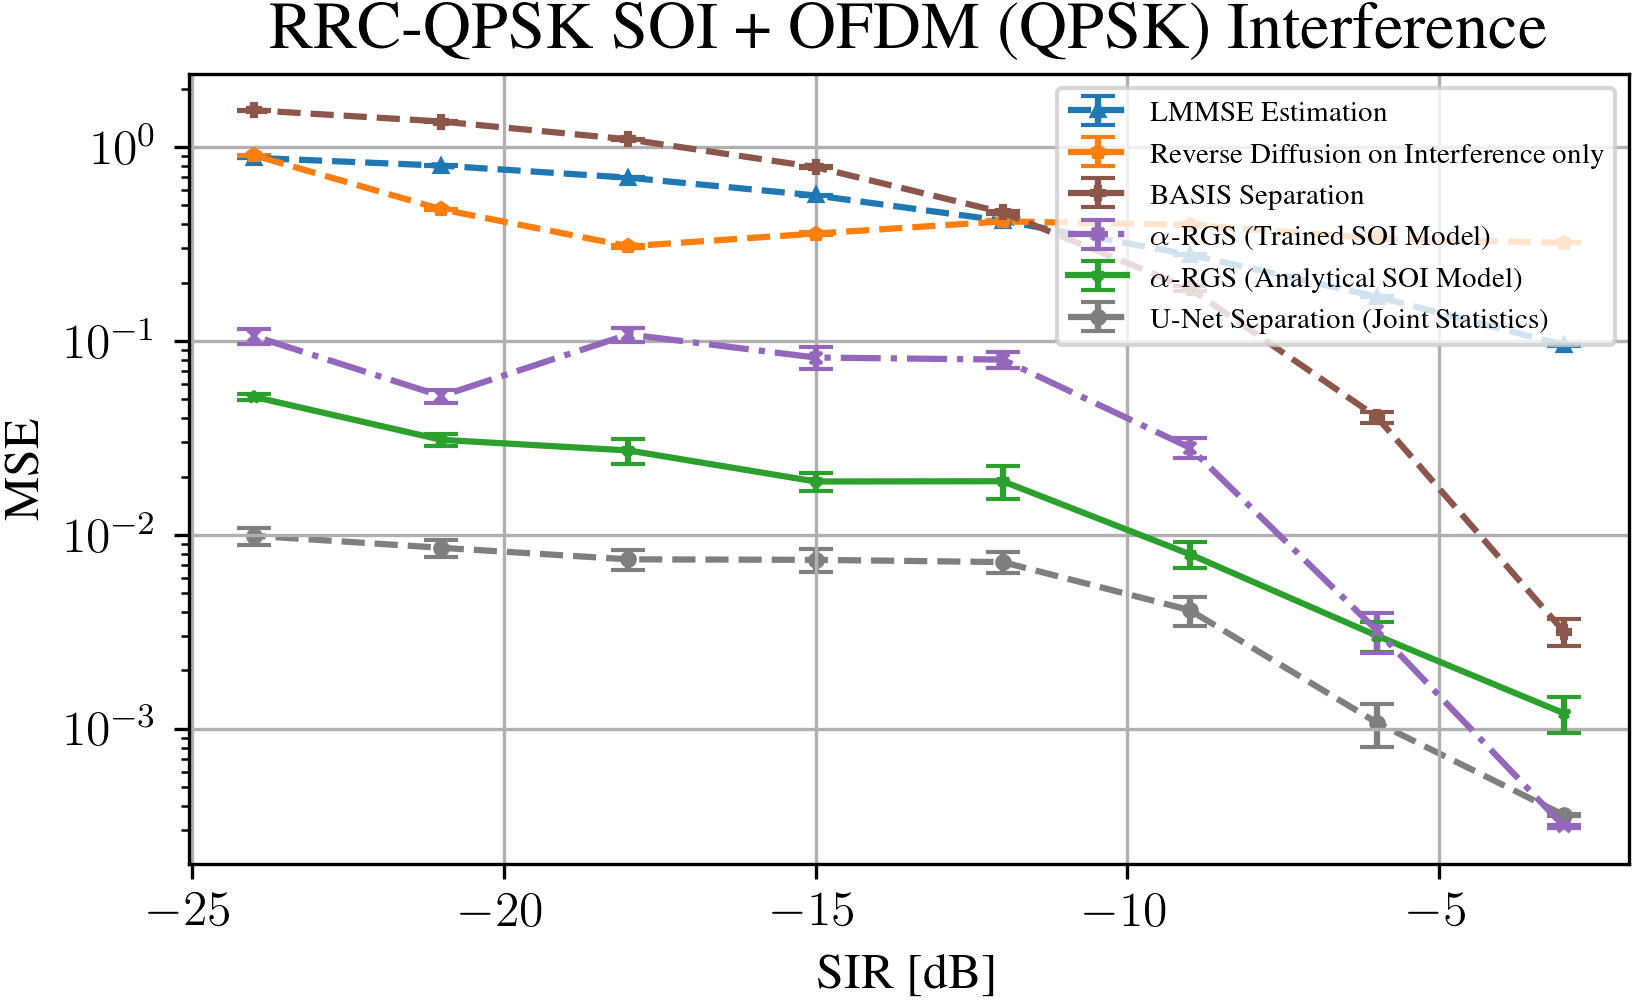

In [49]:
msize = 3

_, _, ber_mf_mean, ber_mf_stderr = get_mean_stderr(all_mse_lmmse, all_ber_mf)
mse_lmmse_mean, mse_lmmse_stderr, ber_lmmse_mean, ber_lmmse_stderr = get_mean_stderr(all_mse_lmmse, all_ber_lmmse)
mse_proj_only_mean, mse_proj_only_stderr, ber_proj_only_mean, ber_proj_only_stderr = get_mean_stderr(all_mse_proj_only, all_ber_proj_only)
mse_basis_mean, mse_basis_stderr, ber_basis_mean, ber_basis_stderr = get_mean_stderr(all_mse_basismod, all_ber_basismod)
mse_unet_mean, mse_unet_stderr, ber_unet_mean, ber_unet_stderr = get_mean_stderr(all_mse_unet, all_ber_unet)

plt.errorbar(sinr_ax, ber_mf_mean, ber_mf_stderr, linestyle='--', marker='d', color='black', capsize=4, label='Matched Filtering (MF) only', markersize=msize)
plt.errorbar(sinr_ax, ber_lmmse_mean, ber_lmmse_stderr, linestyle='--', marker='^', capsize=4, label='LMMSE Estimation + MF', markersize=msize)
plt.errorbar(sinr_ax, ber_proj_only_mean, ber_proj_only_stderr, linestyle='--', marker='p', capsize=4, label='Reverse Diffusion on Interference only + MF', markersize=msize)
for ii, ff in enumerate(cases_to_compare):
    all_mse_est, all_ber_est = pickle.load(open(f'../metrics/{ff}.pkl', 'rb'))
    mse_mean, mse_stderr, ber_mean, ber_stderr = get_mean_stderr(all_mse_est, all_ber_est)
    plt.errorbar(sinr_ax, ber_mean, ber_stderr, linestyle=linestyles[ii][1:], marker=linestyles[ii][0], capsize=4, label=f'$\\alpha$-RGS ({legend_notes[ii]}) + MF', markersize=msize)
    if ii == 0:
        plt.plot([],[]) # skip red
plt.errorbar(sinr_ax, ber_basis_mean, ber_basis_stderr, linestyle='--', marker='P', capsize=4, label='BASIS Separation + MF', zorder=2, markersize=msize)
plt.plot([],[]) # skip pink
plt.errorbar(sinr_ax, ber_unet_mean, ber_unet_stderr, linestyle='--', marker='o', capsize=4, label='U-Net Separation (Joint Statistics) + MF', zorder=1, markersize=msize)
plt.legend(*([ x[i] for i in custom_legend_ordering_BER2 ] for x in plt.gca().get_legend_handles_labels()), loc='upper right')
plt.yscale('log')
plt.grid()
plt.ylim([3.125e-4/4, 0.999])
plt.xlabel('SIR [dB]')
plt.ylabel('BER')
plt.title(f'RRC-QPSK SOI + OFDM (QPSK) Interference', fontsize=16)
plt.savefig('../figs/RRCQPSK_OFDMQPSK_BER_Test_Extra.eps', bbox_inches='tight')
plt.savefig('../figs/RRCQPSK_OFDMQPSK_BER_Test_Extra.png', bbox_inches='tight', dpi=600)
plt.show()

plt.figure()
plt.errorbar(sinr_ax, mse_lmmse_mean, mse_lmmse_stderr, linestyle='--', marker='^', capsize=4, label='LMMSE Estimation', markersize=msize)
plt.errorbar(sinr_ax, mse_proj_only_mean, mse_proj_only_stderr, linestyle='--', marker='p', capsize=4, label='Reverse Diffusion on Interference only', markersize=msize)
for ii, ff in enumerate(cases_to_compare):
    all_mse_est, all_ber_est = pickle.load(open(f'../metrics/{ff}.pkl', 'rb'))
    mse_mean, mse_stderr, ber_mean, ber_stderr = get_mean_stderr(all_mse_est, all_ber_est)
    plt.errorbar(sinr_ax, mse_mean, mse_stderr, linestyle=linestyles[ii][1:], marker=linestyles[ii][0], capsize=4, label=f'$\\alpha$-RGS ({legend_notes[ii]})', markersize=msize)
    if ii == 0:
        plt.plot([],[]) # skip red
plt.errorbar(sinr_ax, mse_basis_mean, mse_basis_stderr, linestyle='--', marker='P', capsize=4, label='BASIS Separation', zorder=2, markersize=msize)
plt.plot([],[]) # skip pink
plt.errorbar(sinr_ax, mse_unet_mean, mse_unet_stderr, linestyle='--', marker='o', capsize=4, label='U-Net Separation (Joint Statistics)', zorder=1, markersize=msize)
plt.legend(*([ x[i] for i in custom_legend_ordering_MSE2 ] for x in plt.gca().get_legend_handles_labels()), loc='upper right')
plt.yscale('log')
plt.grid()
plt.xlabel('SIR [dB]')
plt.ylabel('MSE')
plt.title(f'RRC-QPSK SOI + OFDM (QPSK) Interference', fontsize=16)
plt.savefig('../figs/RRCQPSK_OFDMQPSK_MSE_Test_Extra.eps', bbox_inches='tight')
plt.savefig('../figs/RRCQPSK_OFDMQPSK_MSE_Test_Extra.png', bbox_inches='tight', dpi=600)
plt.show()